## Hierarchical Forecasting

### Introduction

In many applications, a set of time series is hierarchically organized. Examples include the presence of geographic levels, products, or categories that define different types of aggregations.

In such scenarios, forecasters are often required to provide predictions for all disaggregate and aggregate series. A natural desire is for those predictions to be “coherent”, that is, for the bottom series to add up precisely to the forecasts of the aggregated series.



![Figure 1. A two level time series hierarchical structure, with four bottom level variables.](https://raw.github.com/Nixtla/hierarchicalforecast/main/nbs/examples/imgs/hierarchical_motivation1.png)

Figure 1. shows a simple hierarchical structure where we have four bottom-level series, two middle-level series, and the top level representing the total aggregation. 

To visualize an example, in Figure 2. One can think of the hierarchical time series structure levels to represent different geographical aggregations. For example, in Figure 2. the top level is the total aggregation of series within a country, the middle level being its states and the bottom level its regions.



![Figure 1. A two level time series hierarchical structure, with four bottom level variables.](https://raw.github.com/Nixtla/hierarchicalforecast/main/nbs/examples/imgs/hierarchical_motivation2.png)

To achieve “coherency”, most statistical solutions to the hierarchical forecasting challenge implement a two-stage reconciliation process.
1. First, we obtain a set of the base forecast 
2. Later, we reconcile them into coherent forecasts.
 
The HierarchicalForecast library offers a Python collection of reconciliation methods, datasets, evaluation and visualization tools for the task. Among its available reconciliation methods we have BottomUp, TopDown, MiddleOut, MinTrace, ERM. Among its probabilistic coherent methods we have Normality, Bootstrap, PERMBU.



### M5 example

For this tutorial, we will use the data from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy). This is daily-level data from a major retailer in the world.

Let's first import the libraries.

In [1]:
import os

import numpy as np
import pandas as pd

# distributed setting
from dask.distributed import Client, LocalCluster

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import IMAPA, ADIDA, ETS
from statsforecast.distributed.fugue import FugueBackend

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

#evaluation
from datasetsforecast.losses import mse

/Users/fedex/miniconda3/envs/pydata-ts/lib/python3.9/site-packages/statsforecast/core.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


And then, let's read the data.

In [2]:
# Read in the data
unzipped_path = os.path.abspath(os.path.join(".","..","notebooks","data"))
INPUT_DIR = unzipped_path
WORKING_DIR = os.path.join(unzipped_path, "hierarchical")

hierarchical = pd.read_parquet(f"{WORKING_DIR}/hierarchical.parquet")

In [3]:
hierarchical.head()

,unique_id,item_id,dept_id,cat_id,store_id,state_id,ds,y
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-28,0
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-29,0
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-30,0
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-31,0
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-02-01,0


As we can see, the dataset contains daily sales for different items. In addition, it contains information about that item, for example, the `state_id` and the `store_id` where the sale was recorded. This tutorial will focus on a single item (`FOODS_3_090`) to obtain **coherent** hierarchical forecasts.

The objective will be to produce forecasts at three levels:
- National. How much of the product will be sold nationally.
- State. How much product will be sold in each state.
- Store. How much of the product will be sold in each store.

We require the forecasts to be **coherent**. That is, **the sum of the store level forecasts must be equal to the national forecast and the sum of the state level forecasts must be equal to the national forecast**.

In [4]:
hierarchical = (
    hierarchical.query('item_id == "FOODS_3_090"')
                 .groupby(['state_id', 'store_id', 'ds'])
                 .sum(numeric_only=True)
                 .reset_index()
)

In [5]:
hierarchical.head()

,state_id,store_id,ds,y
0,CA,CA_1,2011-01-28,107
1,CA,CA_1,2011-01-29,182
2,CA,CA_1,2011-01-30,47
3,CA,CA_1,2011-01-31,47
4,CA,CA_1,2011-02-01,62


#### Create the hierarchical structure

At the moment, the `hierarchical` dataframe only contains the sales of the product at the `state_id`-`store_id` level. To produce forecasts for the other levels, we must add the national sales column. 

In [6]:
hierarchical.insert(0, 'total', 'USA')

In [7]:
hierarchical.head()

,total,state_id,store_id,ds,y
0,USA,CA,CA_1,2011-01-28,107
1,USA,CA,CA_1,2011-01-29,182
2,USA,CA,CA_1,2011-01-30,47
3,USA,CA,CA_1,2011-01-31,47
4,USA,CA,CA_1,2011-02-01,62


Subsequently, we must obtain the time series of the additional levels. That is, we must obtain the time series of the aggregate national sales and the time series of the aggregate sales of each state. Fortunately, `hierarchicalforecast` includes the `aggregate` function to do this easily. We must pass the time series dataset from the bottom level and specify how we want to aggregate the series. In this case, we want the total (`['total']`), the total by state `['total', 'state_id']`, and the total by state and store `['total', 'state_id', 'store_id']`.

In [8]:
hierarchical, S, tags = aggregate(
    hierarchical,
    spec=[['total'], ['total', 'state_id'], ['total', 'state_id', 'store_id']]
)

The `aggregate` function returns three arguments:
- The dataframe with the time series for all levels of the hierarchy.
- The summing matrix `S`. This matrix indicates which time series should be summed to obtain the top levels of the hierarchy. For example, to obtain the national sales, we must sum all the series at the bottom level. Then the row associated with national sales will have 1 in all its columns.
- `tags`. It is a dictionary that contains for each level, the associated time series.

In [9]:
hierarchical.head()

,ds,y
unique_id,,
USA,2011-01-28,1046
USA,2011-01-29,1036
USA,2011-01-30,673
USA,2011-01-31,642
USA,2011-02-01,531


In [10]:
S.loc['USA']

USA/CA/CA_1    1.0
USA/CA/CA_2    1.0
USA/CA/CA_3    1.0
USA/CA/CA_4    1.0
USA/TX/TX_1    1.0
USA/TX/TX_2    1.0
USA/TX/TX_3    1.0
USA/WI/WI_1    1.0
USA/WI/WI_2    1.0
USA/WI/WI_3    1.0
Name: USA, dtype: float32

In [11]:
tags['total/state_id/store_id']

array(['USA/CA/CA_1', 'USA/CA/CA_2', 'USA/CA/CA_3', 'USA/CA/CA_4',
       'USA/TX/TX_1', 'USA/TX/TX_2', 'USA/TX/TX_3', 'USA/WI/WI_1',
       'USA/WI/WI_2', 'USA/WI/WI_3'], dtype=object)

With `hierarchicalforecast`, we can also obtain plots of the hierarchically linked series. For example, we show the series associated to the `WI_3` store. 

In [12]:
hier_plot = HierarchicalPlot(S=S, tags=tags)

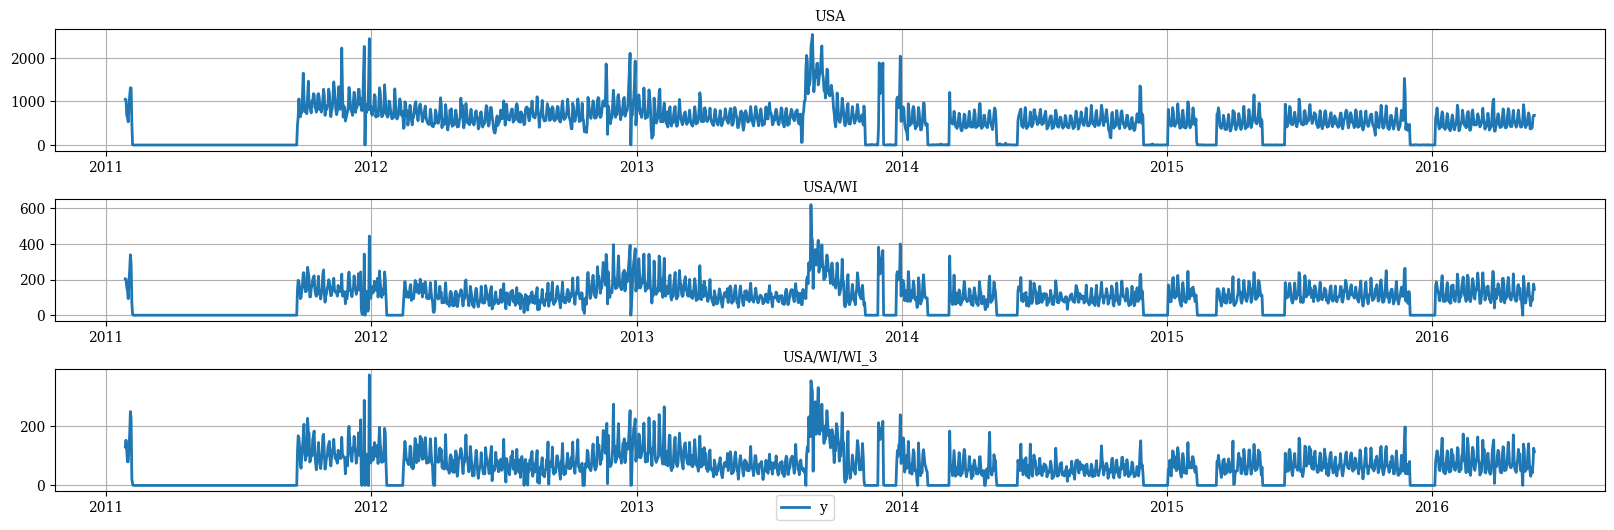

In [13]:
hier_plot.plot_hierarchically_linked_series('USA/WI/WI_3', hierarchical)

### Base Forecasts

Once we have all the series of all hierarchies, we want to generate forecasts for all of them. Note that **there is no guarantee that these forecasts will be coherent**; that is, if we add up all the series at the bottom level (`sotre`), we will not recover the forecasts at the national level. We will show this behavior later. We call these forecasts **base forecasts**.

To produce the base forecasts, we will use `dask` and `fugue`.

In [14]:
cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)

backend = FugueBackend(client)

In this case, we will fit the following models for each of the time series:
- IMAPA
- ADIDA
- ETS

In [15]:
forecasts = backend.forecast(
    df=hierarchical.reset_index(),
    models=[IMAPA(), ADIDA(), ETS(season_length=7, model='ZZA')],
    freq='D',
    h=28,
).compute().set_index('unique_id')

Is it true that forecasts are not consistent? To show this we will use the following function. Basically, it aggregates the forecasts for each of the hierarchy levels. 

In [16]:
def calculate_sum_per_hierarchy(df, tags):
    total_hierarchies = []
    for hierarchy in tags:
        total_h = df.loc[tags[hierarchy]].sum(numeric_only=True).to_frame()
        total_h.columns = [hierarchy]
        total_hierarchies.append(total_h)
    return pd.concat(total_hierarchies, axis=1)

In [17]:
calculate_sum_per_hierarchy(forecasts, tags)

,total,total/state_id,total/state_id/store_id
IMAPA,16541.431641,16541.429688,16515.433594
ADIDA,16541.431641,16541.429688,16515.433594
ETS,15235.757812,15056.915039,14728.458984


As can be seen, no model generates coherent forecasts. 

### Hierarchical Reconciliation

The `hierarchicalforecast` library allows us to take previous forecasts and reconcile them to be coherent. There are several ways to hierarchically reconcile the forecasts. In this case we will use two basic techniques:

- BottomUp: It simply takes the forecasts of the bottom hierarchy and aggregates them.
- MinTrace (ols): Reconcile the forecasts using trace minimization.

In [18]:
reconcilers = [BottomUp(), MinTrace(method='ols')] 
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

The `reconcile` method produces coherent forecasts.

In [19]:
forecasts_reconciled = hrec.reconcile(
    Y_hat_df=forecasts, 
    S=S, tags=tags
)

In [20]:
forecasts_reconciled.head()

,ds,IMAPA,ADIDA,ETS,IMAPA/BottomUp,ADIDA/BottomUp,ETS/BottomUp,IMAPA/MinTrace_method-ols,ADIDA/MinTrace_method-ols,ETS/MinTrace_method-ols
unique_id,,,,,,,,,,
USA/WI/WI_1,2016-05-22,19.447996,19.447996,11.231283,19.447996,19.447996,11.231283,19.552274,19.552274,10.361915
USA/WI/WI_1,2016-05-23,19.447996,19.447996,11.938483,19.447996,19.447996,11.938483,19.552274,19.552274,12.636519
USA/WI/WI_1,2016-05-24,19.447996,19.447996,12.731647,19.447996,19.447996,12.731647,19.552274,19.552274,14.610886
USA/WI/WI_1,2016-05-25,19.447996,19.447996,15.124323,19.447996,19.447996,15.124323,19.552274,19.552274,16.999322
USA/WI/WI_1,2016-05-26,19.447996,19.447996,21.722563,19.447996,19.447996,21.722563,19.552274,19.552274,24.182857


Let's see if the forecasts are now coherent.

In [21]:
calculate_sum_per_hierarchy(forecasts_reconciled, tags)

,total,total/state_id,total/state_id/store_id
IMAPA,16541.431641,16541.429688,16515.433594
ADIDA,16541.431641,16541.429688,16515.433594
ETS,15235.757812,15056.915039,14728.458984
IMAPA/BottomUp,16515.431641,16515.435547,16515.433594
ADIDA/BottomUp,16515.431641,16515.435547,16515.433594
ETS/BottomUp,14728.458984,14728.458008,14728.458984
IMAPA/MinTrace_method-ols,16539.595539,16539.595539,16539.595539
ADIDA/MinTrace_method-ols,16539.595539,16539.595539,16539.595539
ETS/MinTrace_method-ols,15156.402765,15156.402765,15156.402765


As can be seen, the forecasts of each reconciled model are now coherent. Let's plot the forecasts associated to the `WI_3` store.

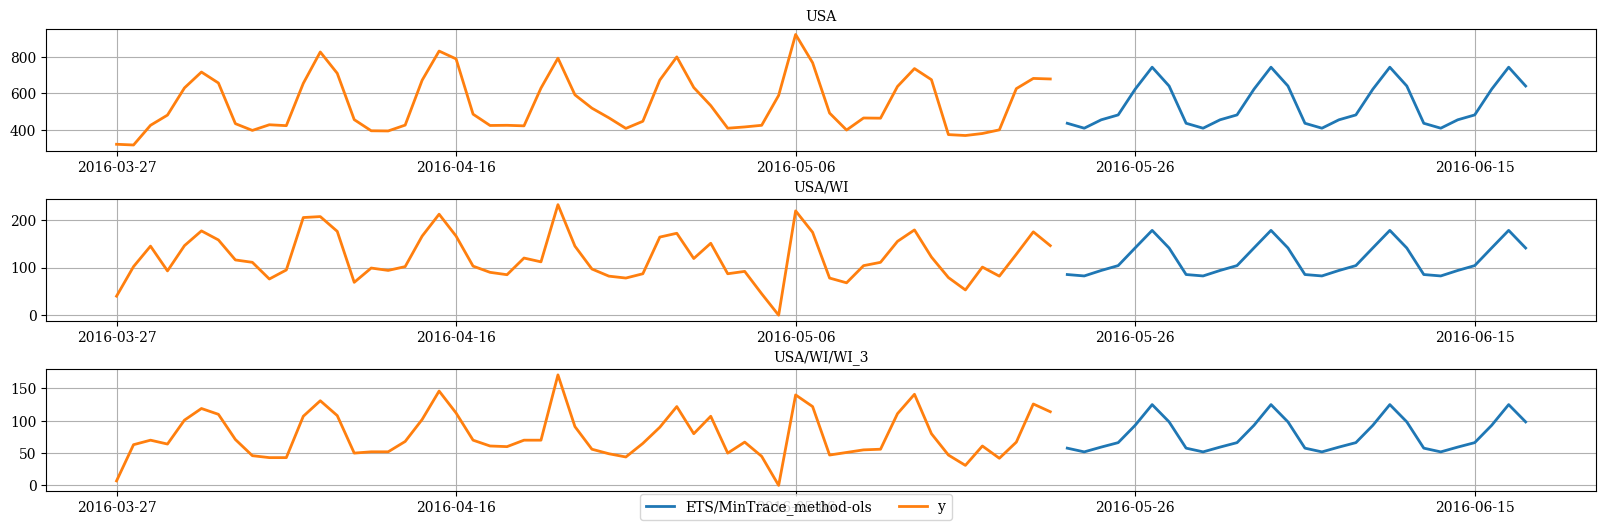

In [22]:
hier_plot.plot_hierarchically_linked_series(
    'USA/WI/WI_3',
    Y_df=pd.concat([hierarchical.groupby('unique_id').tail(28 * 2), forecasts_reconciled]),
    models=['ETS/MinTrace_method-ols', 'y']
)

### Model Selection

In the previous section, we showed how to produce coherent forecasts for different models using different reconciliation techniques. The question remains, which combination of model and reconciliation technique should we use? For this, we will use time series cross validation.

With the distributed backend we can do cross validation in a simple way. In this example, we will use the classic train/test split. We will use as test the last 28 days (`h=28`, `n_windows=1`). 

In [23]:
forecasts_cv = backend.cross_validation(
    df=hierarchical.reset_index(),
    models=[IMAPA(), ADIDA(), ETS(season_length=7, model='ZZA')],
    freq='D',
    h=28, 
    n_windows=1 # classic train/test split
).compute().set_index('unique_id')

In [24]:
forecasts_cv = forecasts_cv.drop(columns='cutoff')

In [25]:
forecasts_cv.head()

,ds,y,IMAPA,ADIDA,ETS
unique_id,,,,,
USA/WI/WI_1,2016-04-24,23.0,23.564091,23.564091,15.454425
USA/WI/WI_1,2016-04-25,6.0,23.564091,23.564091,16.707865
USA/WI/WI_1,2016-04-26,11.0,23.564091,23.564091,17.235037
USA/WI/WI_1,2016-04-27,11.0,23.564091,23.564091,19.452311
USA/WI/WI_1,2016-04-28,43.0,23.564091,23.564091,25.930977


We observe that we obtain the forecasts and the real value of the last 28 days. Now let's show again that these forecasts are not coherent. 

In [26]:
calculate_sum_per_hierarchy(forecasts_cv, tags)

,total,total/state_id,total/state_id/store_id
y,15387.000000,15387.000000,15387.000000
IMAPA,16924.695312,16924.701172,16889.513672
ADIDA,16924.695312,16924.701172,16889.513672
ETS,14772.425781,14885.827148,15015.644531


We reconcile the forecasts as before using the same reconciliation methods. 

In [27]:
forecasts_cv_reconciled = hrec.reconcile(
    Y_hat_df=forecasts_cv, 
    S=S, tags=tags
)

And we get the reconciled forecasts.

In [28]:
calculate_sum_per_hierarchy(forecasts_cv_reconciled, tags)

,total,total/state_id,total/state_id/store_id
y,15387.000000,15387.000000,15387.000000
IMAPA,16924.695312,16924.701172,16889.513672
ADIDA,16924.695312,16924.701172,16889.513672
ETS,14772.425781,14885.827148,15015.644531
IMAPA/BottomUp,16889.515625,16889.511719,16889.513672
ADIDA/BottomUp,16889.515625,16889.511719,16889.513672
ETS/BottomUp,15015.643555,15015.645508,15015.644531
IMAPA/MinTrace_method-ols,16922.161502,16922.161502,16922.161502
ADIDA/MinTrace_method-ols,16922.161502,16922.161502,16922.161502
ETS/MinTrace_method-ols,14814.341115,14814.341115,14814.341115


To evaluate the performance of each combination of model and reconciliation technique, we will use the `HierarchicalEvaluation` class of `hierarchicalforecast`. The class can calculate the evaluation metrics for the different levels. In this case, we will use the `MSE`.

In [29]:
hier_eval = HierarchicalEvaluation(evaluators=[mse])

In [30]:
hier_eval.evaluate(
    Y_hat_df=forecasts_cv_reconciled.drop(columns='y'),
    Y_test_df=forecasts_cv_reconciled[['ds', 'y']], 
    tags=tags
).reset_index(level=1).drop(columns='metric').T.sort_values('Overall')

level,Overall,total,total/state_id,total/state_id/store_id
ETS/BottomUp,799.370911,4062.0354,1362.913208,304.04184
ETS/MinTrace_method-ols,890.113068,4742.284036,1516.65341,316.933869
ETS,893.007629,4958.242676,1501.148682,304.04184
IMAPA/BottomUp,2981.692871,24979.207031,3682.805176,571.608215
ADIDA/BottomUp,2981.692871,24979.207031,3682.805176,571.608215
IMAPA/MinTrace_method-ols,2996.483002,25105.698773,3703.111394,573.572908
ADIDA/MinTrace_method-ols,2996.483002,25105.698773,3703.111394,573.572908
IMAPA,2996.500244,25115.634766,3706.429688,571.608215
ADIDA,2996.500244,25115.634766,3706.429688,571.608215


The overall column contains the overall evaluation for all levels. As can be seen, the best model is ETS reconciled via BottomUp.

Let's look at the behavior of the forecasts generated for the test set. 

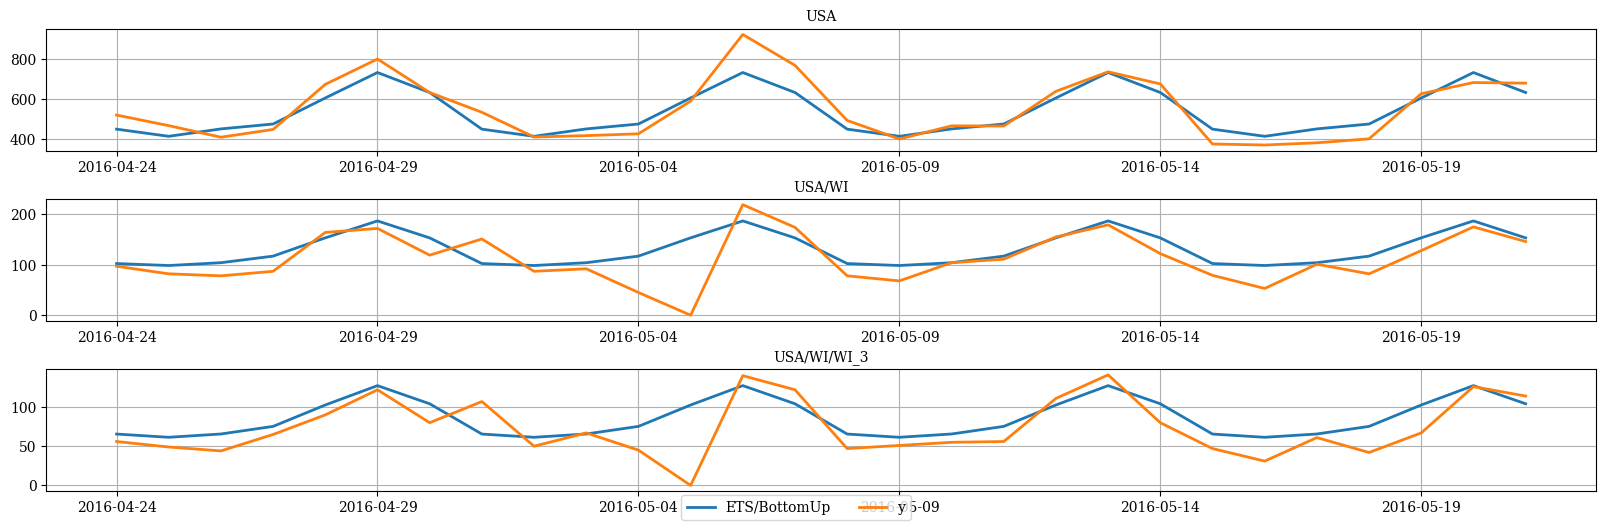

In [31]:
hier_plot.plot_hierarchically_linked_series(
    'USA/WI/WI_3',
    Y_df=forecasts_cv_reconciled,
    models=['ETS/BottomUp', 'y']
)